In [8]:
import random
from transformers import pipeline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
import numpy as np
from huggingface_hub import notebook_login
import wandb
import os
import time
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, get_linear_schedule_with_warmup

%matplotlib inline
%config InlineBackend.figure_format='retina' # 主题

In [9]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
plt.rcParams['figure.figsize'] = 12, 8

In [10]:
# print(torch.__version__)
# print(torch.backends.cudnn.version())
# print(torchvision.__version__)
# print(torchtext.__version__)

In [11]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False  # 启用Cudnn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [12]:
# 模型相关参数
PRETRAIN = False
base_model_name = 'distilbert-base-uncased'
TEST_DATASET_SIZE = 0.4
NUM_LABELS = 3
DATA_PATH = './data/citation_sentiment_corpus_new.csv'
if PRETRAIN:
    BASE_MODEL_PATH = f'./citation_finetuned_models/{base_model_name}_itft'
else:
    BASE_MODEL_PATH = f'./pretrain_models/{base_model_name}'

# 训练相关参数
BATCH_SIZE = 32
loss_type='focal_loss' # 自定义参数 focal_loss dsc_loss ce_loss asymmetric_loss
weight_decay = 0.05  # 0.01
lr = 2.0e-5  # 2e-5学习率，bs设置较大 5e-6
num_epochs = 5
warmup_ratio = 0.1
warmup_steps = 100
label_smoothing_factor = 0.1

# notebook_login()
os.environ["WANDB_PROJECT"] = base_model_name
os.environ["WANDB_LOG_MODEL"] = 'true' # save your trained model checkpoint to wandb
os.environ["WANDB_WATCH"] = 'false' # turn off watch to log faster

In [13]:
df = pd.read_csv(DATA_PATH)
print(df.shape)
df.head()

(8699, 5)


,Source_Paper_ID,Target_Paper_ID,Sentiment,Citation_Text,Sentence_Length
0,A00-1043,A00-2024,0,We analyzed a set of articles and identified s...,486
1,H05-1033,A00-2024,0,Table 3: Example compressions Compression AvgL...,349
2,I05-2009,A00-2024,0,5.3 Related works and discussion Our two-step ...,159
3,I05-2009,A00-2024,0,(1999) proposed a summarization system based o...,368
4,I05-2009,A00-2024,0,We found that the deletion of lead parts did n...,125


## 使用Trainer类微调citation的情感分析

In [14]:
id2label={0:"Neutral", 1:"Positive", 2:"Negative"}
label2id={"Neutral":0, "Positive":1, "Negative":2}

# 加载基座模型和分词器
model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL_PATH, num_labels=NUM_LABELS, id2label=id2label, label2id=label2id).to(device)
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_PATH)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at ./pretrain_models/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
import datasets

class MyDataset(torch.utils.data.Dataset):
    """
    重构数据集类，使其能够返回字典格式的数据，有标签
    """
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


train_texts, temp_texts, train_labels, temp_labels = train_test_split(df['Citation_Text'].tolist(), df['Sentiment'].tolist(), test_size=TEST_DATASET_SIZE, stratify=df['Sentiment'], random_state=seed)
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, stratify=temp_labels, random_state=seed)

train_dataset = MyDataset(tokenizer(train_texts, truncation=True, padding=True, return_tensors='pt', max_length=512), train_labels)
test_dataset = MyDataset(tokenizer(test_texts, truncation=True, padding=True, return_tensors='pt', max_length=512), test_labels)
val_dataset = MyDataset(tokenizer(val_texts, truncation=True, padding=True, return_tensors='pt', max_length=512), val_labels)

# 将数据转换为 HuggingFace 的 Dataset 格式
train_data = datasets.Dataset.from_dict({'text': train_texts, 'label': train_labels})
val_data = datasets.Dataset.from_dict({'text': val_texts, 'label': val_labels})
test_data = datasets.Dataset.from_dict({'text': test_texts, 'label': test_labels})
emotion_data = datasets.DatasetDict({'train': train_data, 'validation': val_data, 'test': test_data})
tokenized_data = emotion_data.map(lambda f: tokenizer(f['text'], padding=True, truncation=True, return_tensors='pt', max_length=512), batch_size=16, batched=True)  # WordPiece分词器
# tokenized_data = tokenized_data.remove_columns(['text'])
# train_dataset = tokenized_data['train']
# val_dataset = tokenized_data['validation']
# test_dataset = tokenized_data['test']

print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")
print(f"Val Dataset Size: {len(val_dataset)}")

Map:   0%|          | 0/5219 [00:00<?, ? examples/s]

Map:   0%|          | 0/1740 [00:00<?, ? examples/s]

Map:   0%|          | 0/1740 [00:00<?, ? examples/s]

Train Dataset Size: 5219
Test Dataset Size: 1740
Val Dataset Size: 1740


In [16]:
# 定义训练参数
training_args = TrainingArguments(
    output_dir=f'./results/{base_model_name}',          # 输出结果目录
    report_to='none',
    num_train_epochs=num_epochs,
    learning_rate=lr,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    weight_decay=weight_decay,
    warmup_ratio=warmup_ratio,
    # warmup_steps=warmup_steps,
    logging_strategy='steps',
    logging_dir=f'./logs/{base_model_name}',            # 日志目录
    logging_steps=50,
    eval_strategy="steps",
    eval_steps=50,
    disable_tqdm=False,
    save_strategy="steps",
    fp16= torch.cuda.is_available(), # faster and use less memory
    metric_for_best_model='F1',
    load_best_model_at_end=True,
    # push_to_hub=True,
    # label_smoothing_factor=label_smoothing_factor
)

In [17]:
# 使用Focal loss作为损失函数解决样本不均衡问题
class MultiFocalLoss(torch.nn.Module):
    """
    Focal_Loss= -1*alpha*((1-pt)**gamma)*log(pt)
    Args:
        num_class: number of classes
        alpha: class balance factor shape=[num_class, ]
        gamma: hyperparameter
        reduction: reduction type
    """

    def __init__(self, num_class, alpha=None, gamma=2.0, reduction='mean'):
        super(MultiFocalLoss, self).__init__()
        self.num_class = num_class
        self.gamma = gamma
        self.reduction = reduction
        self.smooth = 1e-4
        self.alpha = alpha
        
        if alpha is None:
            self.alpha = torch.ones(num_class, ) - 0.5
        elif isinstance(alpha, (int, float)):
            self.alpha = torch.as_tensor([alpha] * num_class)
        elif isinstance(alpha, (list, np.ndarray)):
            self.alpha = torch.as_tensor(alpha)
        if self.alpha.shape[0] != num_class:
            raise RuntimeError('the length not equal to number of class')

    def forward(self, logit, target):
        # assert isinstance(self.alpha,torch.Tensor)\
        alpha = self.alpha.to(logit.device)
        prob = F.softmax(logit, dim=1)

        if prob.dim() > 2:
            # used for 3d-conv:  N,C,d1,d2 -> N,C,m (m=d1*d2*...)
            N, C = logit.shape[:2]
            prob = prob.view(N, C, -1)
            prob = prob.transpose(1, 2).contiguous()  # [N,C,d1*d2..] -> [N,d1*d2..,C]
            prob = prob.view(-1, prob.size(-1))  # [N,d1*d2..,C]-> [N*d1*d2..,C]

        ori_shp = target.shape
        target = target.view(-1, 1)

        prob = prob.gather(1, target).view(-1) + self.smooth  # avoid nan
        logpt = torch.log(prob)
        # alpha_class = alpha.gather(0, target.squeeze(-1))
        alpha_weight = alpha[target.squeeze().long()]
        loss = -alpha_weight * torch.pow(torch.sub(1.0, prob), self.gamma) * logpt

        if self.reduction == 'mean':
            loss = loss.mean()
        elif self.reduction == 'none':
            loss = loss.view(ori_shp)

        return loss

# DSELoss
class MultiDSCLoss(torch.nn.Module):
    r"""
    Creates a criterion that optimizes a multi-class Self-adjusting Dice Loss
    ("Dice Loss for Data-imbalanced NLP Tasks" paper)

    Args:
        alpha (float): a factor to push down the weight of easy examples
        gamma (float): a factor added to both the nominator and the denominator for smoothing purposes
        reduction (string): Specifies the reduction to apply to the output:
            ``'none'`` | ``'mean'`` | ``'sum'``. ``'none'``: no reduction will be applied,
            ``'mean'``: the sum of the output will be divided by the number of
            elements in the output, ``'sum'``: the output will be summed.

    Shape:
        - logits: `(N, C)` where `N` is the batch size and `C` is the number of classes.
        - targets: `(N)` where each value is in [0, C - 1]
    """

    def __init__(self, alpha=1.0, smooth=1.0, reduction="mean"):
        super(MultiDSCLoss, self).__init__()
        self.alpha = alpha
        self.smooth = smooth
        self.reduction = reduction

    def forward(self, logits, targets):
        probs = torch.softmax(logits, dim=1)
        probs = torch.gather(probs, dim=1, index=targets.unsqueeze(1))

        probs_with_factor = ((1 - probs) ** self.alpha) * probs
        loss = 1 - (2 * probs_with_factor + self.smooth) / (probs_with_factor + 1 + self.smooth)

        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        elif self.reduction == "none" or self.reduction is None:
            return loss
        else:
            raise NotImplementedError(f"Reduction `{self.reduction}` is not supported.")

# Asymmetric Loss
class AsymmetricLoss(torch.nn.Module):
    """ 
    Notice - optimized version, minimizes memory allocation and gpu uploading,
    favors inplace operations
    """
    def __init__(self, gamma_neg=4, gamma_pos=1, clip=0.05, eps=1e-8, disable_torch_grad_focal_loss=False):
        super(AsymmetricLoss, self).__init__()

        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.disable_torch_grad_focal_loss = disable_torch_grad_focal_loss
        self.eps = eps

        # prevent memory allocation and gpu uploading every iteration, and encourages inplace operations
        self.targets = self.anti_targets = self.xs_pos = self.xs_neg = self.asymmetric_w = self.loss = None

    def forward(self, x, y):
        """"
        Parameters
        ----------
        x: input logits
        y: targets (multi-label binarized vector)
        """

        self.targets = y
        self.anti_targets = 1 - y

        # Calculating Probabilities
        self.xs_pos = torch.sigmoid(x)
        self.xs_neg = 1.0 - self.xs_pos

        # Asymmetric Clipping
        if self.clip is not None and self.clip > 0:
            self.xs_neg.add_(self.clip).clamp_(max=1)

        # Basic CE calculation
        self.loss = self.targets * torch.log(self.xs_pos.clamp(min=self.eps))
        self.loss.add_(self.anti_targets * torch.log(self.xs_neg.clamp(min=self.eps)))

        # Asymmetric Focusing
        if self.gamma_neg > 0 or self.gamma_pos > 0:
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(False)
            self.xs_pos = self.xs_pos * self.targets
            self.xs_neg = self.xs_neg * self.anti_targets
            self.asymmetric_w = torch.pow(1 - self.xs_pos - self.xs_neg,
                                          self.gamma_pos * self.targets + self.gamma_neg * self.anti_targets)
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(True)
            self.loss *= self.asymmetric_w

        return -self.loss.sum()


class CustomTrainer(Trainer):
    def __init__(self, loss_type='focal_loss', *args, **kwargs):
        super(CustomTrainer, self).__init__(*args, **kwargs)
        self.loss_type = loss_type

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        if self.loss_type == 'focal_loss':
            loss_fct = MultiFocalLoss(num_class=3, alpha=0.8, gamma=2.0)
        elif self.loss_type == 'dsc_loss':
            loss_fct = MultiDSCLoss(alpha=1.0, smooth=1.0)
        elif self.loss_type == 'asymmetric_loss':
            loss_fct = AsymmetricLoss(gamma_pos=0.5, gamma_neg=3.0)
        elif self.loss_type == 'ce_loss':
            loss_fct = torch.nn.CrossEntropyLoss()
        else:
            loss_fct = torch.nn.CrossEntropyLoss()
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [18]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import TrainerCallback

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

class LossRecorderCallback(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.eval_losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if 'loss' in logs:
            self.train_losses.append(logs['loss'])
        if 'eval_loss' in logs:
            self.eval_losses.append(logs['eval_loss'])

    def plot_losses(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_losses, label='Training Loss')
        plt.plot(self.eval_losses, label='Validation Loss')
        plt.xlabel('Steps')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training and Validation Loss over Time')
        plt.show()

loss_recorder = LossRecorderCallback()

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    loss_type=loss_type,  # 自定义参数 focal_loss dsc_loss
    callbacks=[loss_recorder]
)

start = time.time()
results = trainer.train()
train_time = time.time() - start
loss_recorder.plot_losses()
# wandb.finish()

Step,Training Loss,Validation Loss


KeyboardInterrupt: 

## 评估模型:ROC曲线

accuracy、precision(预测为1/真实为1)、recall(真实为1/预测为1)和F1-score

F1-score = 2 * (precision * recall) / (precision + recall)

Micro-F1: 将所有类别的TP、FP、FN分别累加，然后计算F1-score

Macro-F1: 分别计算每个类别的F1-score，然后求平均

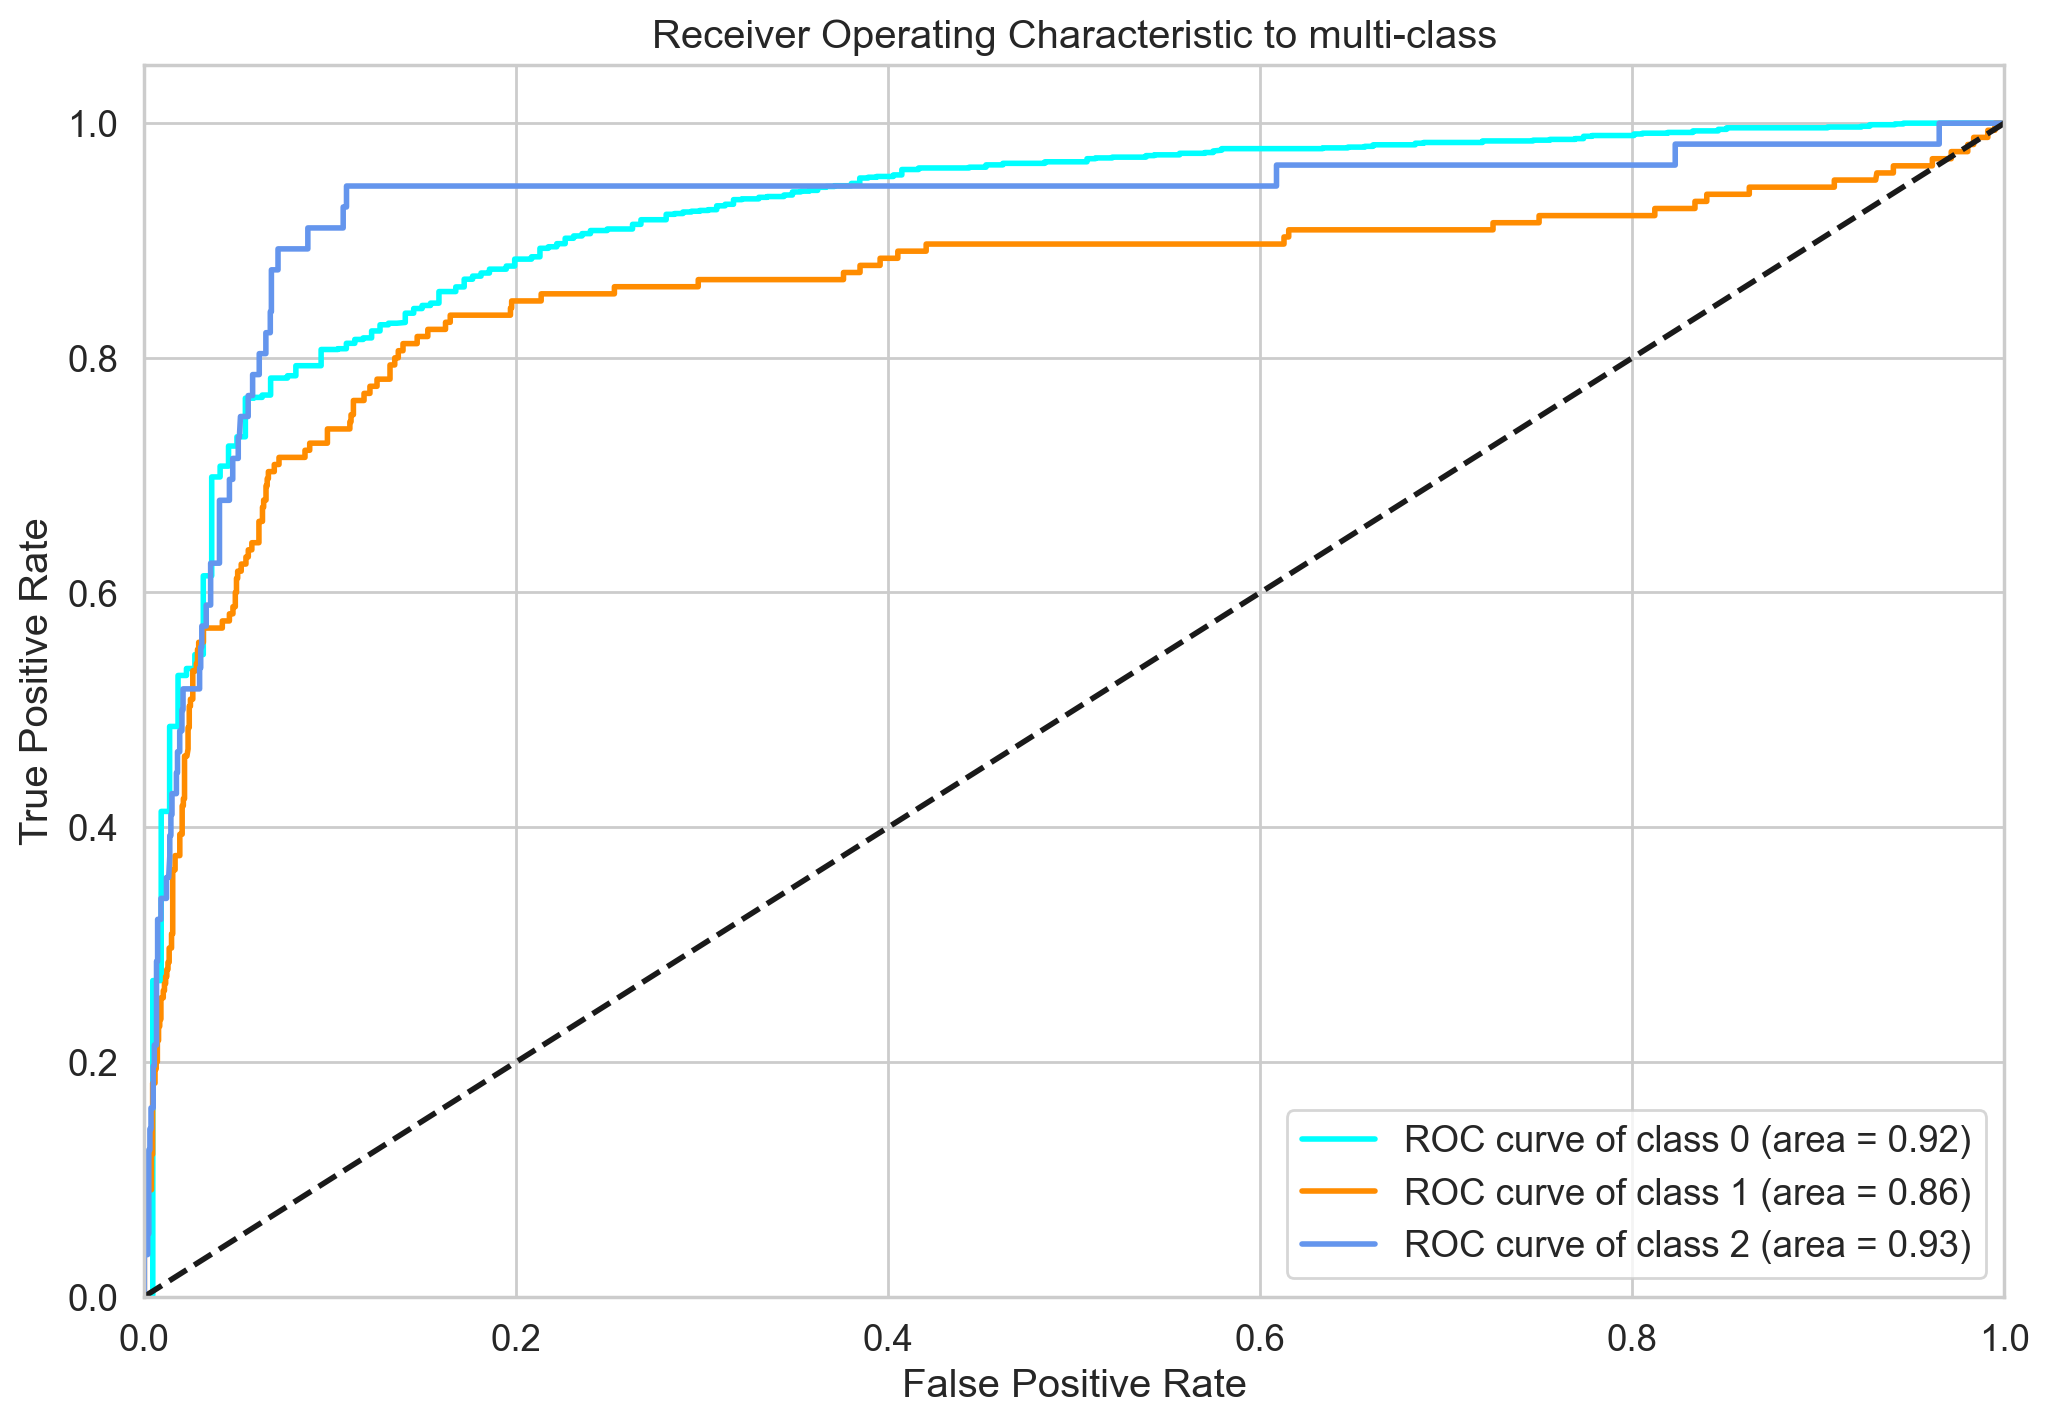

In [12]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
import numpy as np

predictions = trainer.predict(test_dataset)
probs = torch.softmax(torch.tensor(predictions.predictions), dim=-1).numpy()

def plot_roc_curve(labels, probs):
    # 计算ROC曲线
    fpr = {}
    tpr = {}
    roc_auc = {}
    
    # 将标签转换为One-hot编码
    test_labels_one_hot = np.eye(3)[labels]
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(test_labels_one_hot[:, i], probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # 绘制ROC曲线
    plt.figure()
    colors = ['aqua', 'darkorange', 'cornflowerblue']
    for i, color in zip(range(3), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (area = {1:0.2f})'
                                                           ''.format(i, roc_auc[i]))
        
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(test_labels, probs)

## PR曲线

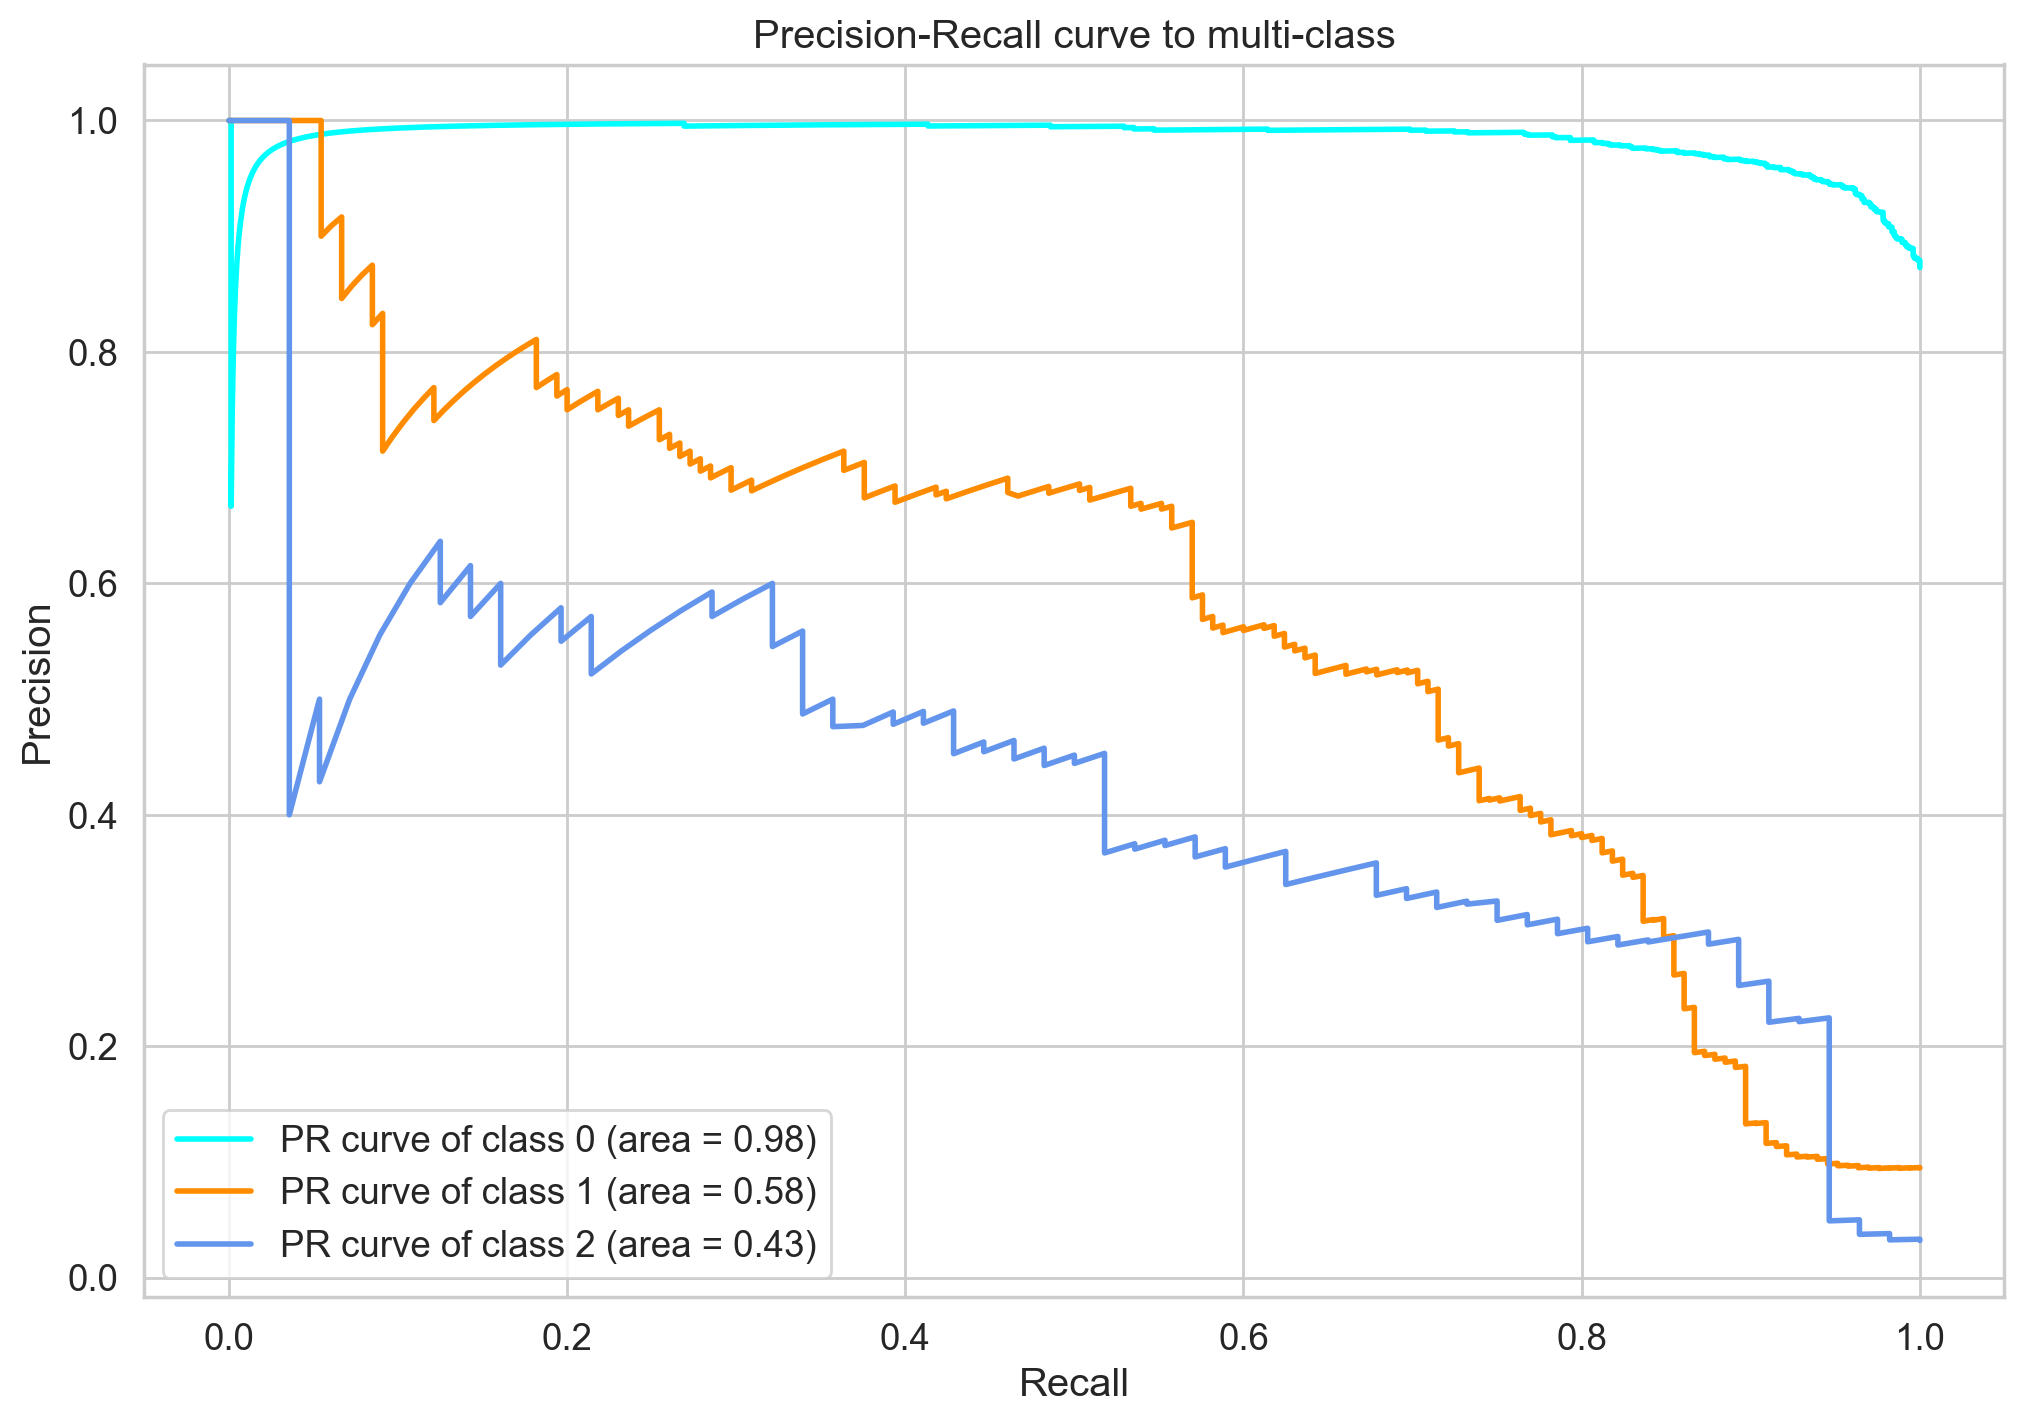

In [13]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_pr_curve(labels, probs):
    
    precision = {}
    recall = {}
    average_precision = {}
    test_labels_one_hot = np.eye(3)[labels]
    
    for i in range(3):
        precision[i], recall[i], _ = precision_recall_curve(test_labels_one_hot[:, i], probs[:, i])
        average_precision[i] = average_precision_score(test_labels_one_hot[:, i], probs[:, i])

    plt.figure()
    colors = ['aqua', 'darkorange', 'cornflowerblue']
    for i, color in zip(range(3), colors):
        plt.plot(recall[i], precision[i], color=color, lw=2, label='PR curve of class {0} (area = {1:0.2f})'
                                                           ''.format(i, average_precision[i]))

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve to multi-class')
    plt.legend(loc="best")
    plt.show()

plot_pr_curve(test_labels, probs)

## 混淆矩阵

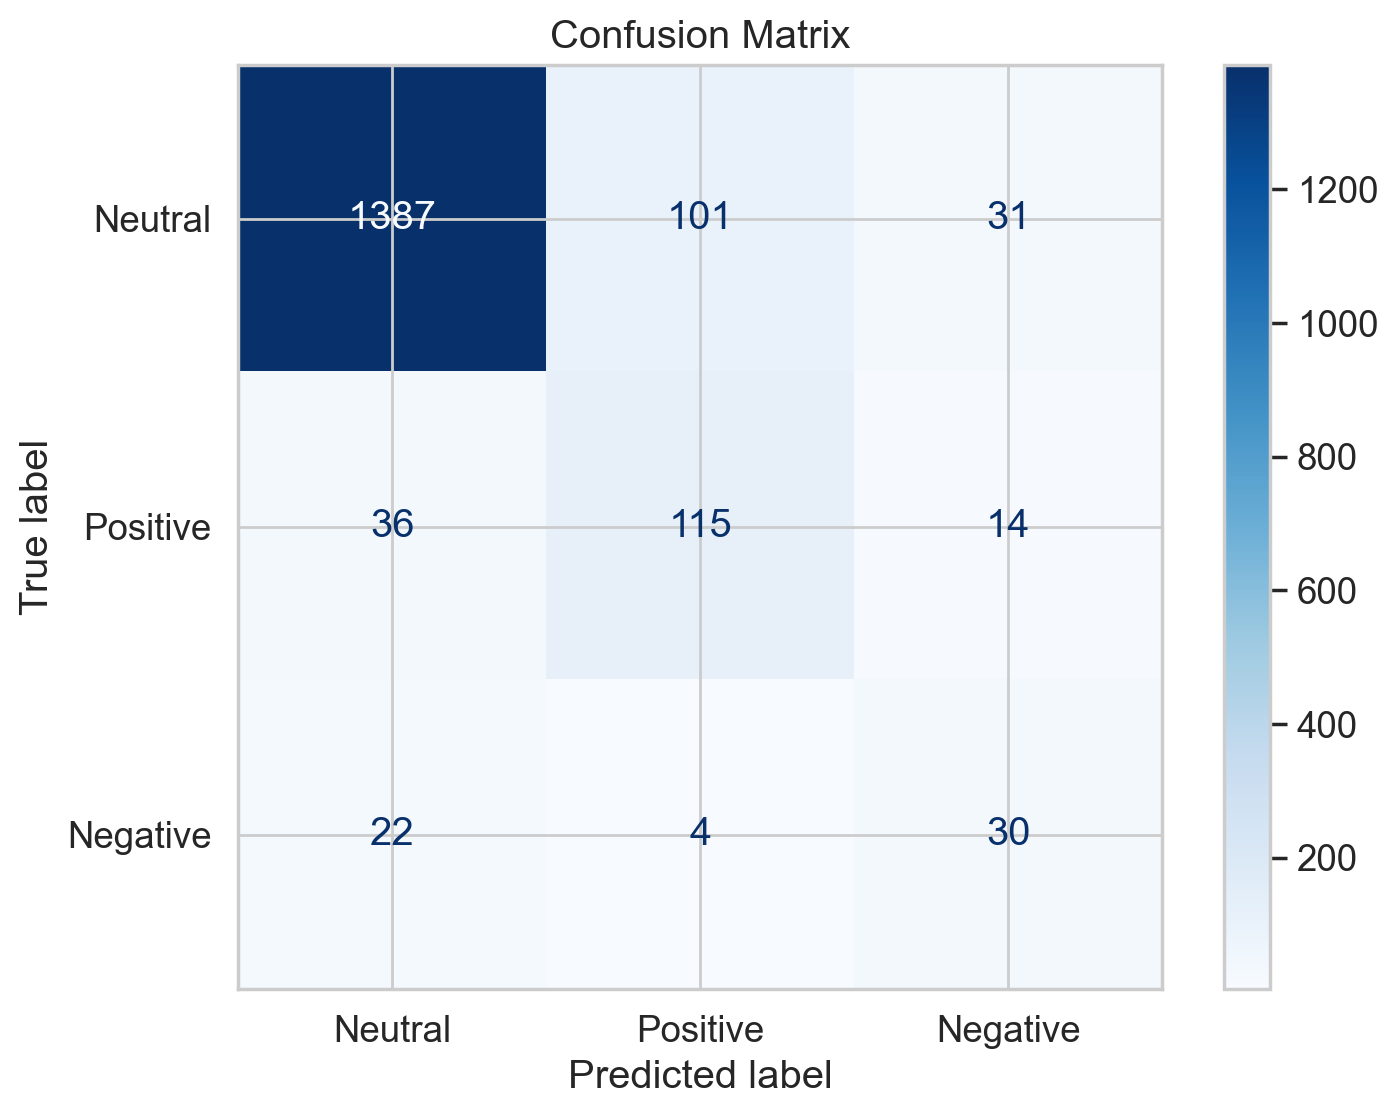

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format='d', ax=ax)
    plt.title('Confusion Matrix')
    plt.show()
    
predicted_labels = np.argmax(predictions.predictions, axis=1)
plot_confusion_matrix(test_labels, predicted_labels, list(label2id.keys()))

## 误差分析

In [15]:
def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        if loss_type == 'dsc_loss':
            loss_fct = MultiDSCLoss(alpha=1.0, smooth=1.0, reduction='none')
        elif loss_type == 'focal_loss':
            loss_fct = MultiFocalLoss(num_class=3, alpha=0.8, gamma=2.0, reduction='none')
        else:
            loss_fct = torch.nn.CrossEntropyLoss(reduction='none')
        loss = loss_fct(output.logits, batch["label"].to(device))

    # Place outputs on CPU for compatibility with other dataset columns   
    return {"loss": loss.cpu().numpy(), 
            "predicted_label": pred_label.cpu().numpy()}

tokenized_data.set_format("torch", columns=["input_ids", "attention_mask", "label"])
tokenized_data["validation"] = tokenized_data["validation"].map(forward_pass_with_label, batched=True, batch_size=16)
tokenized_data.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = tokenized_data["validation"][:][cols]
df_test["label"] = df_test["label"].map(id2label)
df_test["predicted_label"] = (df_test["predicted_label"].map(id2label))
df_test.sort_values("loss", ascending=False).head(10)

Parameter 'function'=<function forward_pass_with_label at 0x00000166B893BB80> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/1740 [00:00<?, ? examples/s]

,text,label,predicted_label,loss
1337,1 Introduction The field of machine translatio...,Negative,Positive,4.042802
1643,Bilexical context-free grammars have been pres...,Negative,Positive,3.768248
1062,Again the best result was obtained with IOB1 (...,Negative,Neutral,3.708789
1215,Many approaches for POS tagging have been deve...,Negative,Neutral,3.600905
126,Sentence-level approximations to B exist (Lin ...,Negative,Neutral,3.258514
745,"To analyze our methods on IV and OOV words, we...",Negative,Neutral,3.035052
86,"This cost can often be substantial, as with th...",Negative,Neutral,2.848522
1095,Such a quasi-syntactic structure can naturally...,Negative,Neutral,2.804732
1707,Our method is a natural extension of those pro...,Negative,Neutral,2.707837
493,We also compare ASIA on twelve additional benc...,Negative,Neutral,2.600394


In [16]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
1057,correspondence points associated with frequent...,Neutral,Neutral,0.000115
748,We scored systems and our own output using cas...,Neutral,Neutral,0.000120
1659,The approach is evaluated by cross-validation ...,Neutral,Neutral,0.000125
1409,"The data set consisting of 249,994 TFSs was ge...",Neutral,Neutral,0.000126
1099,We collected training samples from the Brown C...,Neutral,Neutral,0.000127
830,Our model uses an exemplar memory that consist...,Neutral,Neutral,0.000140
323,We use data from the CoNLL-2004 shared taskthe...,Neutral,Neutral,0.000145
797,3 Experiments and Results All experiments were...,Neutral,Neutral,0.000149
502,"These range from twoword to multi-word, with o...",Neutral,Neutral,0.000152
220,Models describing these types of dependencies ...,Neutral,Neutral,0.000154


In [17]:
from torch.utils.data import DataLoader, ConcatDataset

best_model_dir = f'./citation_finetuned_models/{base_model_name}'
trainer.save_model(best_model_dir)
best_model = AutoModelForSequenceClassification.from_pretrained(best_model_dir).to(device)


# def predict_sentiment_score(model, dataset, batched=True, BATCH_SIZE=32, weights=[-0.5, 1, -1], shuffle=False):
#     '''
#     预测句子的情感
#     '''
#     results = []
#     sentiment_scores = []
#     model.eval()  # 将模型设置为评估模式
# 
#     dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=shuffle)
# 
#     if batched:
#         with torch.no_grad():  # 不计算梯度，以加速和节省内存
#             for batch in dataloader:
#                 # 将批次数据移动到cuda
#                 batch = {k: v.to(device) for k, v in batch.items()}
#                 outputs = model(**batch)
#                 logits = outputs.logits
#                 probabilities = F.softmax(logits, dim=-1)
#                 
#                 logits_list = logits.tolist()
#                 probabilities_list = probabilities.tolist()
#                 results.extend(zip(logits_list, probabilities_list))
#     else:
#         with torch.no_grad():
#             inputs = tokenizer(dataset, return_tensors='pt', truncation=True, padding=True).to(device)
#             outputs = model(**inputs)
#             logits = outputs.logits
#             probabilities = F.softmax(logits, dim=-1)
#             logits_list = logits.tolist()
#             probabilities_list = probabilities.tolist()
#             results.extend(zip(logits_list, probabilities_list))
# 
#     for _, softmax_probs in results:
#         softmax_probs_array = np.array(softmax_probs)
#         weights_array = np.array(weights)
#         score = np.sum(softmax_probs_array * weights_array)
#         score = max(min(score, 1), -1)
#         sentiment_scores.append(score)
#     return sentiment_scores
# 
# weights=[-0.1, 1, -1]
# all_dataset = ConcatDataset([train_dataset, test_dataset, val_dataset])
# sentiment_scores = predict_sentiment_score(best_model, all_dataset, weights=weights, batched=True, BATCH_SIZE=1, shuffle=True) # 句子维度不一样就把BATCH_SIZE设为1
